In [3]:
# Making some essential imports as Usual
import os
import sys
import numpy as np
import re
import cv2 as op
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from os import listdir
import pandas as pd
from keras.layers import Dense, Dropout, Input, add, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose,Activation, Concatenate
from tensorflow import keras
from time import time
from tqdm import tqdm
from keras import backend as K

# plt.style.use('seaborn')
tf.__version__

'2.15.0'

In [4]:
%env SM_FRAMEWORK = tf.keras
!pip install segmentation_models
!pip install  albumentations

env: SM_FRAMEWORK=tf.keras
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.2 MB/s eta 0:00:00


In [5]:
import segmentation_models as sm
sm.__version__

Segmentation Models: using `tf.keras` framework.


'1.0.1'

In [6]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.24.3
re==2.2.1
cv2==4.8.1
tensorflow==2.15.0
pandas==1.5.3
segmentation_models==1.0.1


(1500, 1500, 3)


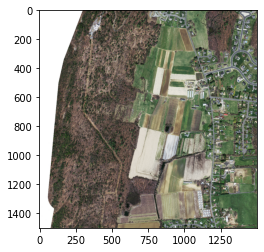

In [5]:
img = plt.imread('../input/massachusetts-roads-dataset/tiff/train/10078705_15.tiff')
print(img.shape)

plt.imshow(img)

In [6]:
def build_data(PATH):
    data = []
    filenames = sorted(listdir(PATH))
    for name in filenames:
        data.append(PATH + '/' + name)
    return data

    
TRAIN_PATH = '../input/massachusetts-roads-dataset/tiff/train'
LABEL_PATH = '../input/massachusetts-roads-dataset/tiff/train_labels'

sat_image = build_data(TRAIN_PATH)
mask_image = build_data(LABEL_PATH)


In [7]:
len(sat_image), len(mask_image)

(1108, 1108)

In [8]:
df = pd.DataFrame({
    'Image' : sat_image,
    'Mask' : mask_image
})


In [9]:
df

,Image,Mask
0,../input/massachusetts-roads-dataset/tiff/trai...,../input/massachusetts-roads-dataset/tiff/trai...
1,../input/massachusetts-roads-dataset/tiff/trai...,../input/massachusetts-roads-dataset/tiff/trai...
2,../input/massachusetts-roads-dataset/tiff/trai...,../input/massachusetts-roads-dataset/tiff/trai...
3,../input/massachusetts-roads-dataset/tiff/trai...,../input/massachusetts-roads-dataset/tiff/trai...
4,../input/massachusetts-roads-dataset/tiff/trai...,../input/massachusetts-roads-dataset/tiff/trai...
...,...,...
1103,../input/massachusetts-roads-dataset/tiff/trai...,../input/massachusetts-roads-dataset/tiff/trai...
1104,../input/massachusetts-roads-dataset/tiff/trai...,../input/massachusetts-roads-dataset/tiff/trai...
1105,../input/massachusetts-roads-dataset/tiff/trai...,../input/massachusetts-roads-dataset/tiff/trai...
1106,../input/massachusetts-roads-dataset/tiff/trai...,../input/massachusetts-roads-dataset/tiff/trai...


In [10]:
import albumentations as A
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Blur(blur_limit = 5, p = 0.85), 
#     A.RandomCrop(height = 512, width = 512, p = 1)
])


In [17]:
IMG_SIZE = (512, 512)

def modify_mask(mask):
    mask = np.expand_dims(mask, axis = 2)
    t_mask = np.zeros(mask.shape)
    np.place(t_mask[:, :, 0], mask[:, :, 0] >=100, 1)
    return t_mask

def map_function(img, mask):
    img, mask = plt.imread(img.decode()), plt.imread(mask.decode())
    img = op.resize(img, IMG_SIZE)
    mask = modify_mask(op.resize(mask, IMG_SIZE))
    
    img = img/255.0
    transformed = transform(image=img, mask=mask)
    img = transformed['image']
    mask = transformed['mask']

#     mask = modify_mask(mask)
    
    return img.astype(np.float64), mask.astype(np.float64)

In [18]:
BATCH_SIZE = 4

def create_dataset(data):
    dataset = tf.data.Dataset.from_tensor_slices((data['Image'], data['Mask']))
    dataset = dataset.shuffle(1000)
    dataset = dataset.map(lambda img, mask : tf.numpy_function(
                    map_function, [img, mask], [tf.float64, tf.float64]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return dataset


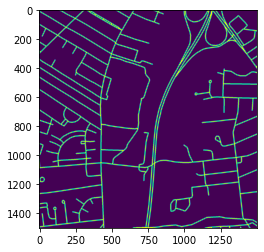

In [19]:
img = plt.imread('../input/massachusetts-roads-dataset/tiff/train_labels/10828810_15.tif')
img = modify_mask(img)

plt.imshow(img)

In [20]:
img.max()

1.0

In [21]:
train_dataset = create_dataset(df)
img, mask = next(iter(train_dataset))
img.shape, mask.shape

(TensorShape([4, 512, 512, 3]), TensorShape([4, 512, 512, 1]))

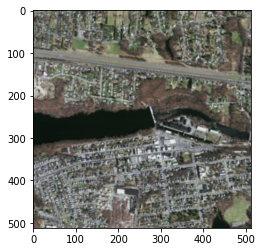

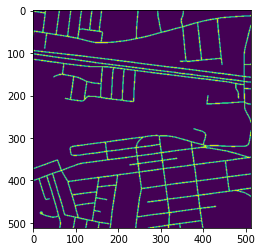

In [24]:
plt.imshow(img[3])
plt.show()
plt.imshow(mask[3])
plt.show()

In [7]:
def dice_coef(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0) 
 
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


In [8]:
def Unet(input_shape,num_classes = 1):
    inp = Input(input_shape)
    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('relu')(x)
    x = MaxPooling2D()(block_1_out)
    x = Dropout(0.2)(x)
    
    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)
    x = MaxPooling2D()(block_2_out)
    x = Dropout(0.2)(x)
    
    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)
    x = MaxPooling2D()(block_3_out)
    x = Dropout(0.2)(x)
    
    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    block_4_out = Activation('relu')(x)

    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP2')(block_4_out)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Concatenate()([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    
    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Concatenate()([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    
    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP4')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Concatenate()([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Conv2D(num_classes, (3, 3), activation='sigmoid', padding='same')(x)

    model = keras.models.Model(inputs=inp, outputs=x)
    adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer = adam,
                  loss = dice_coef_loss,
                  metrics=[dice_coef, sm.metrics.iou_score])
#     model.summary()
    return model

In [9]:
model = Unet(input_shape = (512, 512, 3))

In [10]:
def lr_scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch != 0:
        print("lr changed from {} to {}".format(lr, lr/3))
        return lr/3
    else:
        return lr
    
callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [ ]:
# model.compile(
#     optimizer = keras.optimizers.Adam(),
#     loss = sm.losses.bce_jaccard_loss,
#     metrics = [sm.metrics.iou_score]
# )


In [11]:
model.optimizer.lr.assign(1e-5)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1e-05>

In [ ]:
model.fit(
    train_dataset,
    callbacks = [callback],
    epochs = 5
)


Epoch 1/5
277/277 [==============================] - 135s 441ms/step - loss: 0.8667 - dice_coef: 0.1333 - iou_score: 0.0720
Epoch 2/5
277/277 [==============================] - 123s 443ms/step - loss: 0.8008 - dice_coef: 0.1992 - iou_score: 0.1117
Epoch 3/5
277/277 [==============================] - 123s 442ms/step - loss: 0.7489 - dice_coef: 0.2511 - iou_score: 0.1450
Epoch 4/5
167/277 [=================>............] - ETA: 48s - loss: 0.6907 - dice_coef: 0.3093 - iou_score: 0.1845

In [ ]:
model.save('LOCAL.h5')

In [ ]:
objects = {
    'dice_coef' : dice_coef,
    'dice_coef_loss' : dice_coef_loss,
    'iou_score' : sm.metrics.iou_score
}
model = keras.models.load_model('../input/model1/model_main_loss0.36_iou0.47.h5', custom_objects = objects)

In [ ]:
color = [66, 255, 73]
color = [i/255.0 for i in color]

def placeMaskOnImg(img, mask):
    np.place(img[:, :, :], mask[:, :, :] >= 0.5, color)
    return img

In [ ]:
def make_pred_good(pred):
#     pred = pred.numpy()
    pred = pred[0][:, :, :]
    pred = np.repeat(pred, 3, 2)
    return pred

n = 1
test_img = sorted(listdir('../input/massachusetts-roads-dataset/tiff/test'))[n:n+10]
test_mask = sorted(listdir('../input/massachusetts-roads-dataset/tiff/test_labels'))[n:n+10]

for img, mask in zip(test_img, test_mask):
    plt.figure(figsize = (12,10))
    
    img = plt.imread('../input/massachusetts-roads-dataset/tiff/test/'+img)
    mask = plt.imread('../input/massachusetts-roads-dataset/tiff/test_labels/'+mask)
    mask = modify_mask(op.resize(mask, IMG_SIZE))
    img = (img/255.0)
    transformed = transform(image=img, mask=mask)
    img = transformed['image']
    mask = transformed['mask']

    img = np.expand_dims(op.resize(img, (512, 512)), 0)
    img = img.astype(np.float32)
    
    pred = make_pred_good(model(img))
    mask = make_pred_good(np.expand_dims(mask, axis = 0))
    
    plt.subplot(1,3,1)
    plt.title("Satellite")
    plt.imshow(img[0])
    plt.subplot(1,3,2)
    plt.title('Actual mask')
    plt.imshow(mask)
    plt.subplot(1,3,3)
    plt.title('Predicted mask')
    pred = placeMaskOnImg(img[0], pred)
    plt.imshow(pred)
    
    plt.show()


In [24]:
objects = {
    'dice_coef' : dice_coef,
    'dice_coef_loss' : dice_coef_loss,
    'iou_score' : sm.metrics.iou_score
}
model = keras.models.load_model('model_save.h5', custom_objects = objects)
def make_pred_good(pred):
#     pred = pred.numpy()
    pred = pred[0][:, :, :]
    pred = np.repeat(pred, 3, 2)
    return pred
    
color = [66, 255, 73]
color = [i/255.0 for i in color]

def placeMaskOnImg(img, mask):
    np.place(img[:, :, :], mask[:, :, :] >= 0.5, color)
    return img

(600, 600, 3)


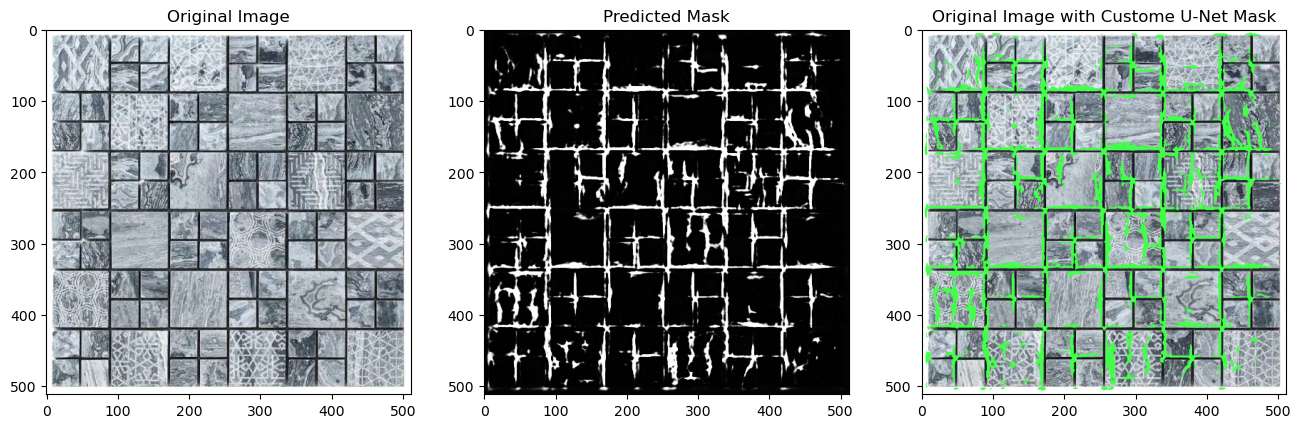

In [36]:


url = 'https://i.postimg.cc/05w75S3M/d1.webp'
import requests, io
import numpy as np
from PIL import Image

response = requests.get(url)
bytes_im = io.BytesIO(response.content)
img = np.array(Image.open(bytes_im))[:, :, :3]
print(img.shape)
img = img/255.0
img = op.resize(img, (512,512))
img = np.expand_dims(img, axis = 0)

plt.figure(figsize = (16, 12))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img[0])

plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
pred = make_pred_good(model(img))
plt.imshow(pred)

plt.subplot(1,3,3)
plt.title("Original Image with Custome U-Net Mask")
pred = placeMaskOnImg(img[0], pred)
plt.imshow(pred)
# plt.savefig('pred.jpg')

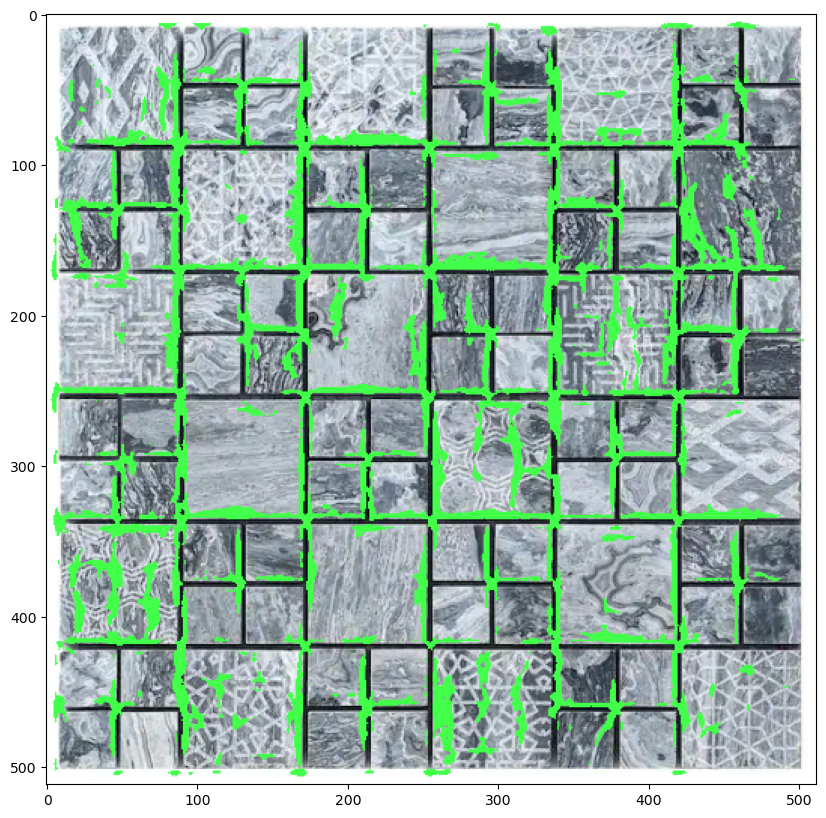

In [35]:
plt.figure(figsize = (12,10))
plt.imshow(pred)
plt.savefig('pred.jpg')